Step 2: Task and Dataset Selection

In [1]:

import torch
import os
import json
from datasets import DatasetDict
from transformers import AutoModelForSequenceClassification,AutoTokenizer
from datasets import load_dataset
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')
dataset = load_dataset("yaful/DeepfakeTextDetect")


device: cpu


In [2]:
import torch
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
text = 'Hello everyone! ! antidisestablishmentarianism'
for t in [tokenizer]:
  print(f'\n\n{tokenizer.name_or_path}')
  vocab = {v: k for k, v in t.vocab.items()}
  tokenized_text = t(text)
  print([vocab[id] for id in tokenized_text['input_ids']])

from datasets import Dataset
def preprocess_function(examples):
    return tokenizer(examples['text'], padding=True, truncation=True)
tokenized_data_train = dataset['train'].map(preprocess_function, batched=True)
tokenized_data_test = dataset['validation'].map(preprocess_function, batched=True)




distilbert-base-uncased
['[CLS]', 'hello', 'everyone', '!', '!', 'anti', '##dis', '##est', '##ab', '##lish', '##ment', '##arian', '##ism', '[SEP]']


Map:   0%|          | 0/56792 [00:00<?, ? examples/s]

In [3]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [4]:
import evaluate
# Proportion of correct predictions among the total number of cases processed
accuracy = evaluate.load('accuracy')

In [5]:
import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)
labels = ['Not Human', 'Human']
id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in id2label.items()}
print('id2label:', id2label)
print('label2id:', label2id)
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(labels), id2label=id2label, label2id=label2id
)

id2label: {0: 'Not Human', 1: 'Human'}
label2id: {'Not Human': 0, 'Human': 1}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step 3: Choosing Model and Model Training with CustomTrainer

In [6]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir='deep_fake_model',
    learning_rate= 2e-5 ,
    per_device_train_batch_size=15,
    per_device_eval_batch_size=15,
    num_train_epochs=5,
    weight_decay=0.001,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    use_mps_device=True
)

/Users/dhondupdolma/Desktop/CSCI_NLP/.env/lib/python3.11/site-packages/transformers/training_args.py:1895: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(


In [19]:
from tqdm import tqdm
import time
import math
import torch
# loss function takes the pair of inputs and computes a value that estimates how far away the predicted output is from the target
# calling loss.backward()  the entire graph is differentiated w.r.t. the loss, and all variables in the graph will have their .grad var accumulated with the gradient
# to backpropogate the error, first clear all gradient and call the loss.backward() 
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def _inner_training_loop(self, batch_size=None, args=None, resume_from_checkpoint=None, trial=None, ignore_keys_for_eval=None):
        number_of_epochs = args.num_train_epochs
        start = time.time()
        criterion = torch.nn.CrossEntropyLoss().to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=args.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=0.9)
        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader()
        
        for epoch in range(number_of_epochs):
            self.model.train()
            train_loss_per_epoch = 0
            train_correct_total = 0
            total_train_samples = 0
            
            max_steps = math.ceil(args.num_train_epochs * len(train_dataloader))
            with tqdm(train_dataloader, unit="batch") as training_epoch:
                training_epoch.set_description(f"Training Epoch {epoch}")
                print(len(training_epoch))
                for step, inputs in enumerate(training_epoch):
                    # Move inputs and labels to the correct device
                    inputs['device'] = device
                    input_ids = inputs['input_ids']
                    labels = inputs['labels']
                    # zero gradient
                    self.optimizer.zero_grad()
                    # forward pass
                    outputs =  self.model(input_ids,labels = labels)
                    logits = outputs.logits
                    #  compute loss
                    loss = criterion(logits, labels)
                    train_loss_per_epoch += loss.item()
                    #  backpropogate
                    loss.backward()
                    # update weights
                    self.optimizer.step()
                    # performs a parameter update based on the current gradient stored in self.grad
                    # backward 
                    train_correct_total += (logits.argmax(dim=1) == labels).sum().item()
                    total_train_samples += labels.size(0)
                print("train_correct_total: ", train_correct_total," total_train_samples: ", total_train_samples)
            self.scheduler.step()
            train_loss_per_epoch /= len(train_dataloader)
            train_accuracy = train_correct_total / total_train_samples
            self.model.eval()
            eval_loss_per_epoch = 0
            eval_correct_total = 0
            total_eval_samples = 0
            with torch.no_grad():
                with tqdm(eval_dataloader, unit="batch") as eval_epoch:
                    eval_epoch.set_description(f"Evaluation Epoch {epoch}")
                    for step, inputs in enumerate(eval_epoch):
                        input_ids = inputs['input_ids']
                        labels = inputs['labels']
                        outputs =  self.model(input_ids, labels = labels)
                        logits = outputs.logits
                        loss = criterion(logits, labels)
                        eval_loss_per_epoch += loss.item()
                        eval_correct_total += (logits.argmax(dim=1) == labels).sum().item()
                        total_eval_samples += labels.size(0)
                    print("eval_correct_total: ", eval_correct_total," total_eval_samples: ", total_eval_samples)

            eval_loss_per_epoch /= len(eval_dataloader)
            eval_accuracy = eval_correct_total / total_eval_samples
            print(f'\tTrain Loss: {train_loss_per_epoch:.3f} | Train Acc: {train_accuracy*100:.2f}%')
            print(f'\tEval Loss: {eval_loss_per_epoch:.3f} | Eval Acc: {eval_accuracy*100:.2f}%')
        print(f'Time: {(time.time()-start)/60:.3f} minutes')


trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data_train,
    eval_dataset=tokenized_data_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics= compute_metrics,
)
trainer.train()

Training Epoch 0:   0%|                                                                                                                                                                  | 0/21272 [00:00<?, ?batch/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


21272


Training Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21272/21272 [8:04:51<00:00,  1.37s/batch]


train_correct_total:  299170  total_train_samples:  319071


Evaluation Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3787/3787 [22:29<00:00,  2.81batch/s]


eval_correct_total:  47552  total_eval_samples:  56792
	Train Loss: 0.153 | Train Acc: 93.76%
	Eval Loss: 0.393 | Eval Acc: 83.73%


Training Epoch 1:   0%|                                                                                                                                                                  | 0/21272 [00:00<?, ?batch/s]

21272


Training Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21272/21272 [7:57:25<00:00,  1.35s/batch]


train_correct_total:  311047  total_train_samples:  319071


Evaluation Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3787/3787 [23:28<00:00,  2.69batch/s]


eval_correct_total:  48346  total_eval_samples:  56792
	Train Loss: 0.065 | Train Acc: 97.49%
	Eval Loss: 0.440 | Eval Acc: 85.13%


Training Epoch 2:   0%|                                                                                                                                                                  | 0/21272 [00:00<?, ?batch/s]

21272


Training Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21272/21272 [8:12:45<00:00,  1.39s/batch]


train_correct_total:  315202  total_train_samples:  319071


Evaluation Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3787/3787 [22:09<00:00,  2.85batch/s]


eval_correct_total:  50594  total_eval_samples:  56792
	Train Loss: 0.032 | Train Acc: 98.79%
	Eval Loss: 0.374 | Eval Acc: 89.09%


Training Epoch 3:   0%|                                                                                                                                                                  | 0/21272 [00:00<?, ?batch/s]

21272


Training Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21272/21272 [7:53:59<00:00,  1.34s/batch]


train_correct_total:  316763  total_train_samples:  319071


Evaluation Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3787/3787 [22:27<00:00,  2.81batch/s]


eval_correct_total:  49368  total_eval_samples:  56792
	Train Loss: 0.020 | Train Acc: 99.28%
	Eval Loss: 0.509 | Eval Acc: 86.93%


Training Epoch 4:   0%|                                                                                                                                                                  | 0/21272 [00:00<?, ?batch/s]

21272


Training Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21272/21272 [7:56:43<00:00,  1.34s/batch]


train_correct_total:  317560  total_train_samples:  319071


Evaluation Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3787/3787 [22:30<00:00,  2.80batch/s]

eval_correct_total:  49904  total_eval_samples:  56792
	Train Loss: 0.013 | Train Acc: 99.53%
	Eval Loss: 0.546 | Eval Acc: 87.87%
Time: 2518.849 minutes


In [20]:
output_dir = "./deep_fake_model"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./deep_fake_model/tokenizer_config.json',
 './deep_fake_model/special_tokens_map.json',
 './deep_fake_model/vocab.txt',
 './deep_fake_model/added_tokens.json',
 './deep_fake_model/tokenizer.json')

Step 4: Evaluation of three types of test sets: test, test_ood_gpt_para, test_ood_gpt. 

In [11]:
# Test Accuracy on Out-of-distribution Detection
import time
dataset = load_dataset("yaful/DeepfakeTextDetect")
model_test = AutoModelForSequenceClassification.from_pretrained("/Users/dhondupdolma/Desktop/CSCI_NLP/deep_fake_model/")
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
start = time.time()
tokenized_data_test = dataset['test_ood_gpt_para'].map(preprocess_function, batched=True)

test_correct_total = 0
total_test_samples = 0
criterion = torch.nn.CrossEntropyLoss().to(device)
with torch.no_grad():
    for step, inputs in enumerate(tokenized_data_test):
        input_ids =  torch.tensor([inputs['input_ids']])
        labels = torch.tensor([inputs['label']])
        outputs =  model_test(input_ids, labels = labels, output_hidden_states=True)
        logits = outputs.logits
        loss = criterion(logits, labels)
        test_correct_total += (logits.argmax(dim=1) == labels).sum().item()
        total_test_samples += labels.size(0)

print("test_correct_total: ", test_correct_total," total_test_samples: ", total_test_samples)
print(f'Time: {(time.time()-start)/60:.3f} minutes')


test_correct_total:  1765  total_test_samples:  2362
Time: 4.703 minutes


In [12]:
test_accuracy = test_correct_total / total_test_samples
print(f'Test ood para Acc: {test_accuracy*100:.2f}%')

Test ood para Acc: 74.72%


In [13]:
dataset = load_dataset("yaful/DeepfakeTextDetect")
# Test Accuracy on Out-of-distribution Detection
start = time.time()
tokenized_data_test = dataset['test_ood_gpt'].map(preprocess_function, batched=True)
test_correct_total = 0
total_test_samples = 0
criterion = torch.nn.CrossEntropyLoss().to(device)
logit_lst= []
loss_lst=[]
labels_lst = []
with torch.no_grad():
    for step, inputs in enumerate(tokenized_data_test):
        input_ids =  torch.tensor([inputs['input_ids']])
        labels = torch.tensor([inputs['label']])
        outputs =  model_test(input_ids, labels = labels)
        logits = outputs.logits
        logit_lst.append(logits)
        loss = criterion(logits, labels)
        loss_lst.append(loss.item())
        test_correct_total += (logits.argmax(dim=1) == labels).sum().item()
        labels_lst.append((logits.argmax(dim=1) == labels).sum().item())
        total_test_samples += labels.size(0)

print("test_correct_total: ", test_correct_total," total_test_samples: ", total_test_samples)
test_accuracy = test_correct_total / total_test_samples
print(f'Test ood Acc: {test_accuracy*100:.2f}%')
print(f'Time: {(time.time()-start)/60:.3f} minutes')



test_correct_total:  1222  total_test_samples:  1562
Test ood Acc: 78.23%
Time: 3.277 minutes


In [9]:
# Test Accuray of In-distibution detection
tokenized_data_test = dataset['test'].map(preprocess_function, batched=True)
test_correct_total = 0
total_test_samples = 0
criterion = torch.nn.CrossEntropyLoss().to(device)
start = time.time()
with torch.no_grad():
    for step, inputs in enumerate(tokenized_data_test):
        input_ids =  torch.tensor([inputs['input_ids']])
        labels = torch.tensor([inputs['label']])
        outputs =  model_test(input_ids, labels = labels)
        logits = outputs.logits
        loss = criterion(logits, labels)
        test_correct_total += (logits.argmax(dim=1) == labels).sum().item()
        total_test_samples += labels.size(0)

print("test_correct_total: ", test_correct_total," total_test_samples: ", total_test_samples)
test_accuracy = test_correct_total / total_test_samples
print(f'Test Acc: {test_accuracy*100:.2f}%')
print(f'Time: {(time.time()-start)/60:.3f} minutes')

test_correct_total:  49996  total_test_samples:  56819
Test Acc: 87.99%
Time: 104.046 minutes


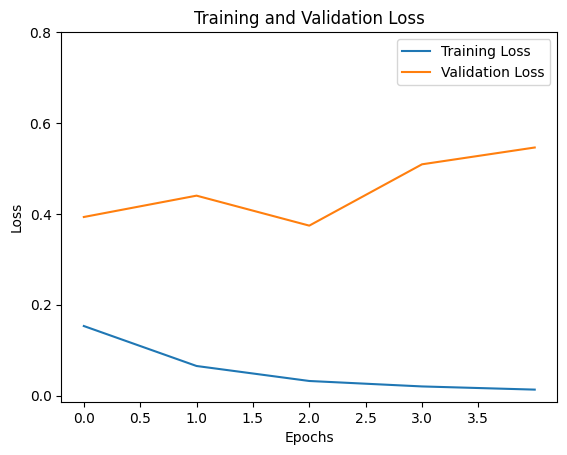

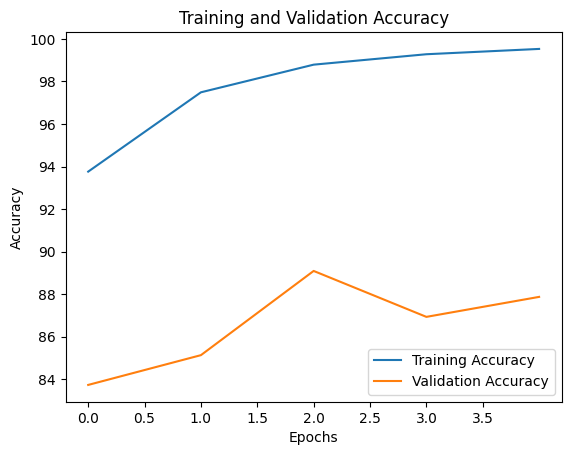

In [10]:
# from deployment import preprocess, detect
from matplotlib.pylab import plt
from numpy import arange
train_loss = {0:0.153,1:0.065 , 2: 0.032, 3: .020, 4: 0.013  }
train_acc ={0: 93.76,1: 97.49, 2: 98.79, 3: 99.28, 4:99.53}	
validation_loss = {0: 0.393 ,1: 0.440,2: 0.374, 3:0.509, 4: 0.546}
valid_acc = {0:83.73,1:85.13,2: 89.09 ,3:86.93,4:87.87 }

epochs = range(0,5)
plt.plot(epochs, train_loss.values(), label='Training Loss')
plt.plot(epochs, validation_loss.values(), label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.yticks(arange(0, 1, .2))
plt.xticks(arange(0, 4, .5))
# Display the plot
plt.legend(loc='best')
plt.show()
epochs = range(0,5)
plt.plot(epochs, train_acc.values(), label='Training Accuracy')
plt.plot(epochs, valid_acc.values(), label='Validation Accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Set the tick locations
plt.xticks(arange(0, 4, .5))

# Display the plot
plt.legend(loc='best')
plt.show()

Inference:

In [15]:
start = time.time()

from transformers import pipeline
model_test = AutoModelForSequenceClassification.from_pretrained("/Users/dhondupdolma/Desktop/CSCI_NLP/deep_fake_model/")
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
classifier = pipeline("text-classification", model=model_test, tokenizer=tokenizer, device=device)
text ="If any of you frequent rbadhistory, there is a rather infamous [chart] that captures a popular perception of the Middle Ages as a \"dark age\" that retarded scientific progress by over 1,000 years. This perception is incorrect but is still commonplace. I believe that the Bush years will be viewed similarly by future generations for the following reasons: The much disputed election in Florida was a huge challenge to the world's second-largest democracy. Having the Supreme Court effectively appoint a president upon party lines significantly hurt faith in the US political process and led to the polarization that has led to the Do-Nothing Congresses of 2006-2008 and 2010-. Bush's decision to go to war in Iraq eroded the brief period of global consensus that saw countries from Iran to Russia united in sympathy with the USA against Al-Qaeda. I'm not saying we would be at world peace thereafter, but we could have taken advantage of that unity to seriously reduce international conflict. Climate change. Need I say more? The Bush years saw inaction on global climate change that has endangered every country on earth. Imperialism. The expansion of the War on Terror to Iraq and other groups was correlated with a rise of police militarization (in the US) and espionage (globally) and led to the installation of treasonous quisling governments around Europe. Economic instability. The 2008 housing bubble (heavily concentrated in, you guessed it, Florida) triggered a global financial crisis that the world has yet to recover from. The progress that the world's 99, overwhelmingly located in developing countries like China and India, made during the 2000s has almost completely been [reversed] by this fucking crisis. Global equity markets are now [as US-centric] as they've ever been since at least the Eighties, meaning that \"the rise of the rest\" has been an utter illusion. Erosion in quality of living. In addition to the phony \"development\" of countries like China and India, Western countries have seen a large absolute drop in well-being due to the financial crisis of the Bush years, a drop which treaties like TPP and TTIP may well enshrine into law. TL;DR: If the world is a dystopia in 2200, George W. Bush will be (rightfully or not) blamed."
classifier(text)
inputs = tokenizer(text, return_tensors='pt').to(device)  # 'pt' means your tokenizer will return a pytorch tensor
from transformers import AutoModelForSequenceClassification
with torch.no_grad():
    logits = model(**inputs).logits
predicted_class_id = logits.argmax().item() # is the first output or second output bigger? get ID of bigger output
print(model.config.id2label[predicted_class_id]) # translate ID to human-readable label
print(f'Time: {(time.time()-start)/60:.3f} minutes')

Not Human
Time: 0.015 minutes


(Bonus +1) Step 6: Visualize errors and perform qualitative analysis

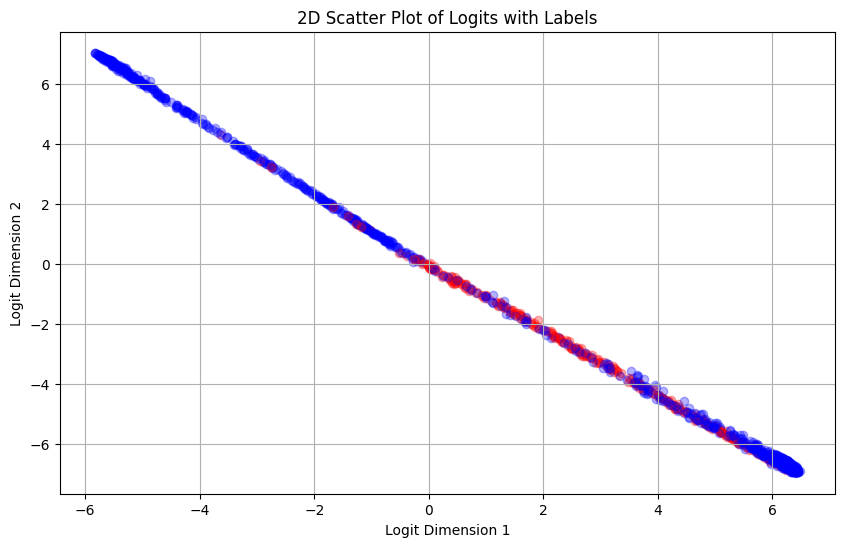

In [21]:

import numpy as np
import matplotlib.pyplot as plt
logits_np = np.array([logit.numpy() for logit in logit_lst]).squeeze()
# Scatter plot
colors = ['red' if label == 0 else 'blue' for label in labels_lst]
plt.figure(figsize=(10, 6))
for i, color in enumerate(colors):
    plt.scatter(logits_np[i, 0], logits_np[i, 1], color=color, alpha=0.3)
plt.title('2D Scatter Plot of Logits with Labels')
plt.xlabel('Logit Dimension 1')
plt.ylabel('Logit Dimension 2')
plt.grid(True)
plt.show()